# Comparison of the AE and VAE models

When $\beta$ and $\epsilon$ are set to 0, the VAE model becomes the same as the AE model. The KL divergence term in the VAE loss function becomes vanishes, and the reparameterization yields the mean of the encoder output. In this case, the VAE model should be able to learn the same representation as the AE model.

Epoch [100/2000], Loss: 36.8989
Epoch [200/2000], Loss: 1.6673
Epoch [300/2000], Loss: 0.3823
Epoch [400/2000], Loss: 0.1074
Epoch [500/2000], Loss: 0.0363
Epoch [600/2000], Loss: 0.0253
Epoch [700/2000], Loss: 0.0231
Epoch [800/2000], Loss: 0.0102
Epoch [900/2000], Loss: 0.0198
Epoch [1000/2000], Loss: 0.0208
Epoch [1100/2000], Loss: 0.0679
Epoch [1200/2000], Loss: 0.5271
Epoch [1300/2000], Loss: 0.2888
Epoch [1400/2000], Loss: 0.0067
Epoch [1500/2000], Loss: 2.1693
Epoch [1600/2000], Loss: 0.0028
Epoch [1700/2000], Loss: 0.0078
Epoch [1800/2000], Loss: 0.0210
Epoch [1900/2000], Loss: 0.0130
Epoch [2000/2000], Loss: 0.0037
Epoch [100/2000], Loss: 141.6814
Epoch [200/2000], Loss: 27.4972
Epoch [300/2000], Loss: 8.3310
Epoch [400/2000], Loss: 3.5686
Epoch [500/2000], Loss: 1.6980
Epoch [600/2000], Loss: 0.9626
Epoch [700/2000], Loss: 3.0779
Epoch [800/2000], Loss: 0.5572
Epoch [900/2000], Loss: 0.4789
Epoch [1000/2000], Loss: 0.5468
Epoch [1100/2000], Loss: 0.0923
Epoch [1200/2000], Los

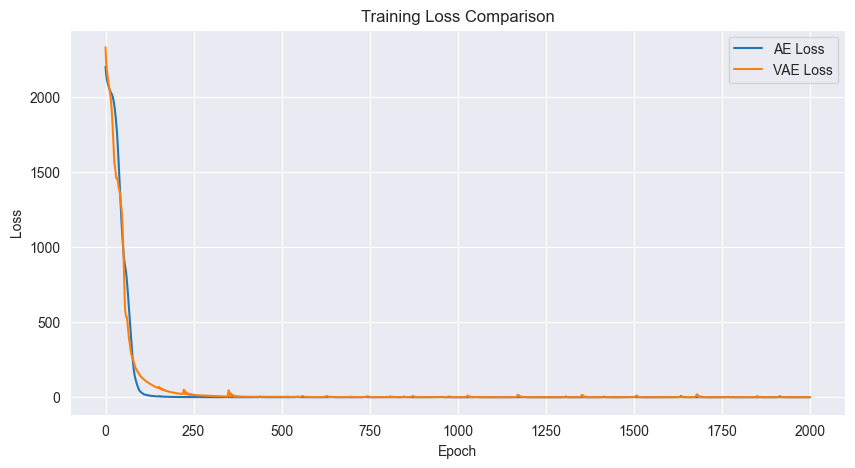

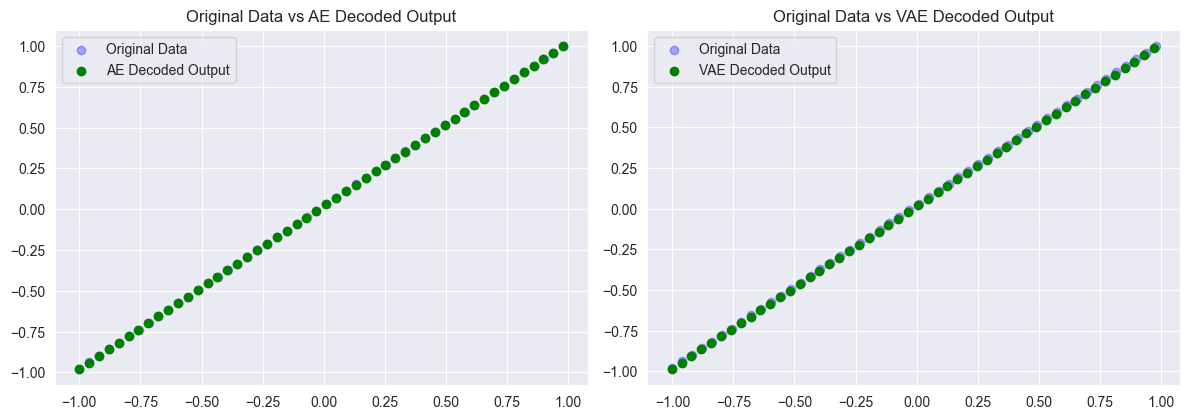

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class AE_VAE(nn.Module):
    def __init__(self, mode='vae', scale=1e-6, beta=1):
        super(AE_VAE, self).__init__()
        self.mode = mode
        self.scale = scale
        self.beta = beta
        
        self.encoder_fc = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(4, 2)
        self.fc_logvar = nn.Linear(4, 2)
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std * self.scale

    def encode(self, x):
        h = self.encoder_fc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        if self.mode == 'vae':
            mu, logvar = self.encode(x)
            z = self.reparameterize(mu, logvar)
            return self.decode(z), mu, logvar
        else:
            mu, _ = self.encode(x)
            return self.decode(mu), None, None

    def loss_function(self, recon_x, x, mu=None, logvar=None, mode='vae'):
        BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
        if mode == 'vae':
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            return BCE + self.beta * KLD
        else:
            return BCE

def train_model(model, data, epochs=2000):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar, mode=model.mode)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    return losses

mean = torch.zeros(2)
cov = torch.eye(2)
mvn = torch.distributions.MultivariateNormal(mean, cov)
data = mvn.sample((1000,))

ae_model = AE_VAE(mode='ae')
ae_losses = train_model(ae_model, data)

vae_model = AE_VAE(mode='vae', beta=0, scale=0)
vae_losses = train_model(vae_model, data)

sample_data = mvn.sample((10000,))
sample_data = torch.linspace(-1, 1, 100).view(-1, 2)

def plot_comparison(ae_model, vae_model, sample_data):
    with torch.no_grad():
        ae_decoded, ae_mu, _ = ae_model(sample_data)

    with torch.no_grad():
        vae_decoded, vae_mu, vae_logvar = vae_model(sample_data)

    plt.figure(figsize=(12, 8))

    # plt.subplot(2, 2, 1)
    # plt.title('Original Data vs AE Encoded Means')
    # plt.scatter(sample_data[:, 0], sample_data[:, 1], color='blue', alpha=0.3, label='Original Data')
    # plt.scatter(ae_mu[:, 0], ae_mu[:, 1], color='red', label='AE Encoded Means')
    # plt.legend()

    plt.subplot(2, 2, 1)
    plt.title('Original Data vs AE Decoded Output')
    plt.scatter(sample_data[:, 0], sample_data[:, 1], color='blue', alpha=0.3, label='Original Data')
    plt.scatter(ae_decoded[:, 0], ae_decoded[:, 1], color='green', label='AE Decoded Output')
    plt.legend()
    
    # plt.subplot(2, 2, 3)
    # plt.title('Original Data vs VAE Encoded Means')
    # plt.scatter(sample_data[:, 0], sample_data[:, 1], color='blue', alpha=0.3, label='Original Data')
    # plt.scatter(vae_mu[:, 0], vae_mu[:, 1], color='red', label='VAE Encoded Means')
    # plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.title('Original Data vs VAE Decoded Output')
    plt.scatter(sample_data[:, 0], sample_data[:, 1], color='blue', alpha=0.3, label='Original Data')
    plt.scatter(vae_decoded[:, 0], vae_decoded[:, 1], color='green', label='VAE Decoded Output')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_losses(ae_losses, vae_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(ae_losses, label='AE Loss')
    plt.plot(vae_losses, label='VAE Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(ae_losses, vae_losses)

plot_comparison(ae_model, vae_model, sample_data)

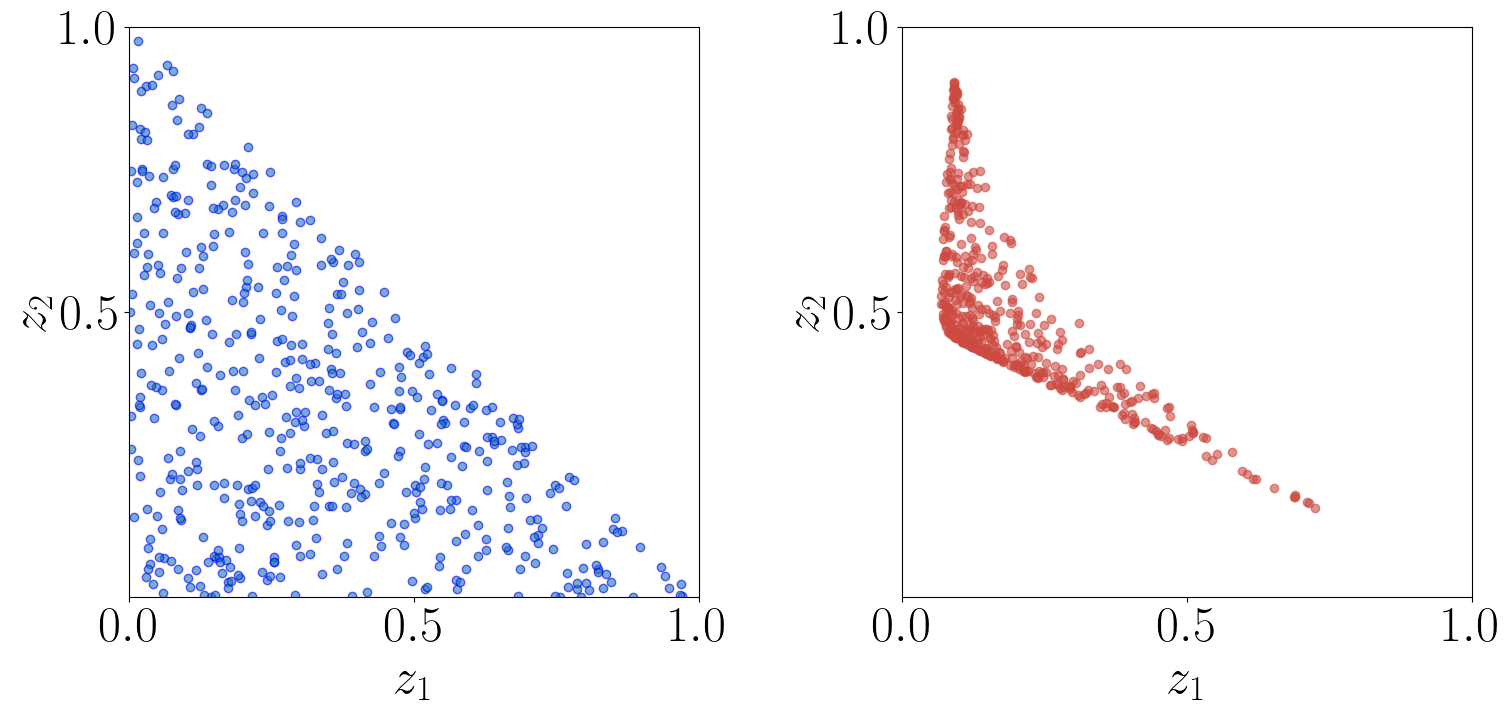

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Use LaTeX fonts for Matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 36  # Adjust this value for larger/smaller fonts
})

# Function to sample points uniformly within the simplex (triangle)
def sample_points_in_simplex(n_points=1000):
    u = np.random.uniform(0, 1, (n_points, 2))
    mask = u[:, 0] + u[:, 1] <= 1
    return u[mask]

# Linear transformation matrix
A = np.array([[2, 1], [1, 2]])

# Nonlinear transformation function
def nonlinear_transform(z):
    z1 = 0.1 * np.exp(z[:, 0]**2)
    z2 = np.tanh(z[:, 1]**2)
    return np.array([z1/(z1 + z2 + 1), 1/(z1 + z2 + 1)]).T 

# Generate points in the simplex
n_points = 1000
z = sample_points_in_simplex(n_points)

# Apply linear transformation
Az = z @ A.T

# Apply nonlinear transformation
fAz = nonlinear_transform(Az)

# Apply Gaussian noise to the nonlinearly transformed data
noise_std = 0.05  # Standard deviation of Gaussian noise
fAz_noisy = fAz + np.random.normal(0, noise_std, fAz.shape)

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Adjust figure size as needed

# Function to make square plots with automatic limits
def make_square(ax):
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    # Configure ticks: display 0 on x-axis but skip 0 for y-axis
    x_ticks = np.linspace(0, 1, 3)  # Generate ticks from 0 to 1
    y_ticks = np.linspace(0, 1, 3)  # Generate ticks from 0 to 1
    y_ticks = y_ticks[y_ticks != 0]  # Exclude 0 from y-axis ticks
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

# Plot 1: Points in the simplex
axes[0].scatter(z[:, 0], z[:, 1], alpha=0.6, edgecolor='blue')
axes[0].set_xlabel(r'$z_1$')
axes[0].set_ylabel('$z_2$')
make_square(axes[0])

# Plot 2: Nonlinearly distorted points in the simplex
axes[1].scatter(fAz[:, 0], fAz[:, 1], alpha=0.6, color=(204/255, 74/255, 64/255))
axes[1].set_xlabel('$z_1$')
axes[1].set_ylabel('$z_2$')
make_square(axes[1])

plt.subplots_adjust(hspace=0.3, wspace=0.6)

plt.tight_layout()

plt.savefig('figures/vae-deterministic_regime.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()